### **EXP1 Predicitng Missing Cell-Types from Bulks using Non-Negative Least Squares regression Residual**

*This file includes EXP1 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Code based on:
1. https://github.com/nrosed/sc_bulk_ood/blob/main/sc_preprocessing/2_make_pseudobulks/scanpy_sc_preprocess_pbmc6k.ipynb
2. https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

**Data Details:**

Data downloaded from: https://www.10xgenomics.com/resources/datasets/6-k-pbm-cs-from-a-healthy-donor-1-standard-1-1-0

PBMC 6k

Organism: Homo sapiens

Characteristics	tissue: blood

**Experimental Details:**

Expanding on the complexity, we used a widely characterized PBMC 3k dataset from 10x Genomics. A random proportion vector dictated bulk creation, while references underwent successive removals of 1, 2, 3, and 4 randomly selected cell types. We increase complexity further by adding two more deconvolution methods: regression-based NNLS, Bayesian-based BayesPrism, and marker-based CIBERSORTx. For NNLS, the normalization and deconvolution procedures paralleled the previous section. The NNLS function was supplied with references having 0, 1, 2, 3, or 4 randomly missing cell types, and iterative deconvolution was executed for 1000 bulks of random proportions. The performance of NNLS deconvolution was assessed for each number of missing cell types through the calculation of Pearson’s correlation and RMSE between the calculated and real proportions from the pseudobulks.

*This file can be run one kernel at a time, or all at once*

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_pbmc_EXP1"
actual_path = os.getcwd()
path = f"{actual_path}/../data/"
aug_data_path = f"{actual_path}/../data/EXP1/"
cibersort_path = f"{aug_data_path}/cibersort/"
adata_path = f"{actual_path}/../data/"
#if you want pseudobulks to be made, change to True before running:
make_pseudos = False
prep_cibersort =True  #to extract genes
#if too many obs per anndata, limit celltypes
#define the cell types to limit and the desired maximum number of cells
limit_celltypes = True
cell_types_to_limit = []
max_cells_per_type = 550

**Reading in all the data:**

In [3]:
data_path = f"{path}filtered_gene_bc_matrices/hg19"
#adata containing count matrix
adata = sc.read_10x_mtx(data_path, var_names='gene_symbols', cache = True)
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## **QC of count matrix:**

Based on:
Scanpy https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
adata.var_names_make_unique() 

scanpy==1.9.3 anndata==0.7.8 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0.2 statsmodels==0.13.0 python-igraph==0.9.9 pynndescent==0.5.10


normalizing counts per cell
    finished (0:00:00)


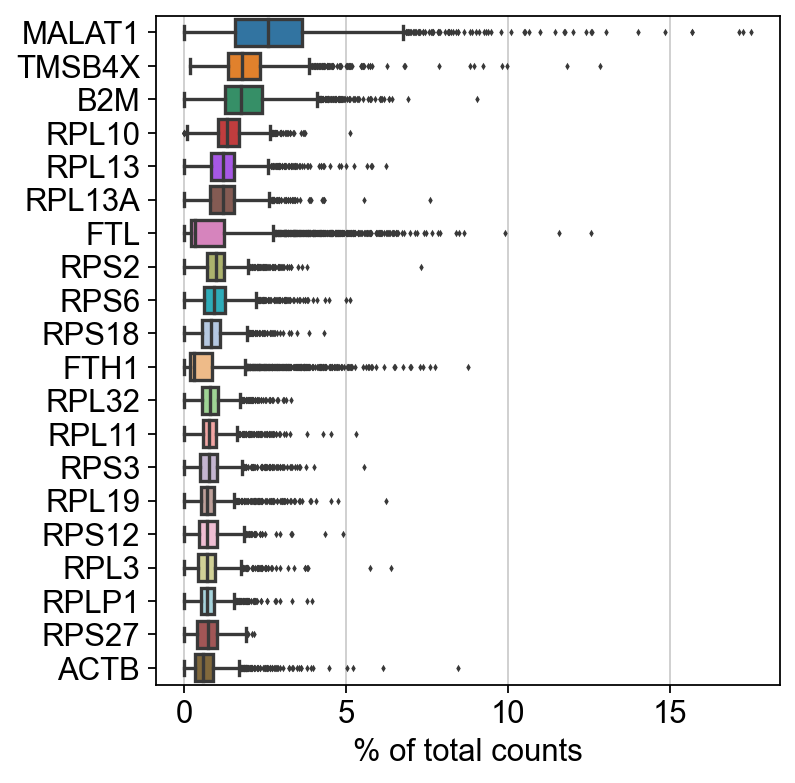

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic Filtering:

In [6]:
#filtering genes present in less than 3 cells:
#and cells with less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


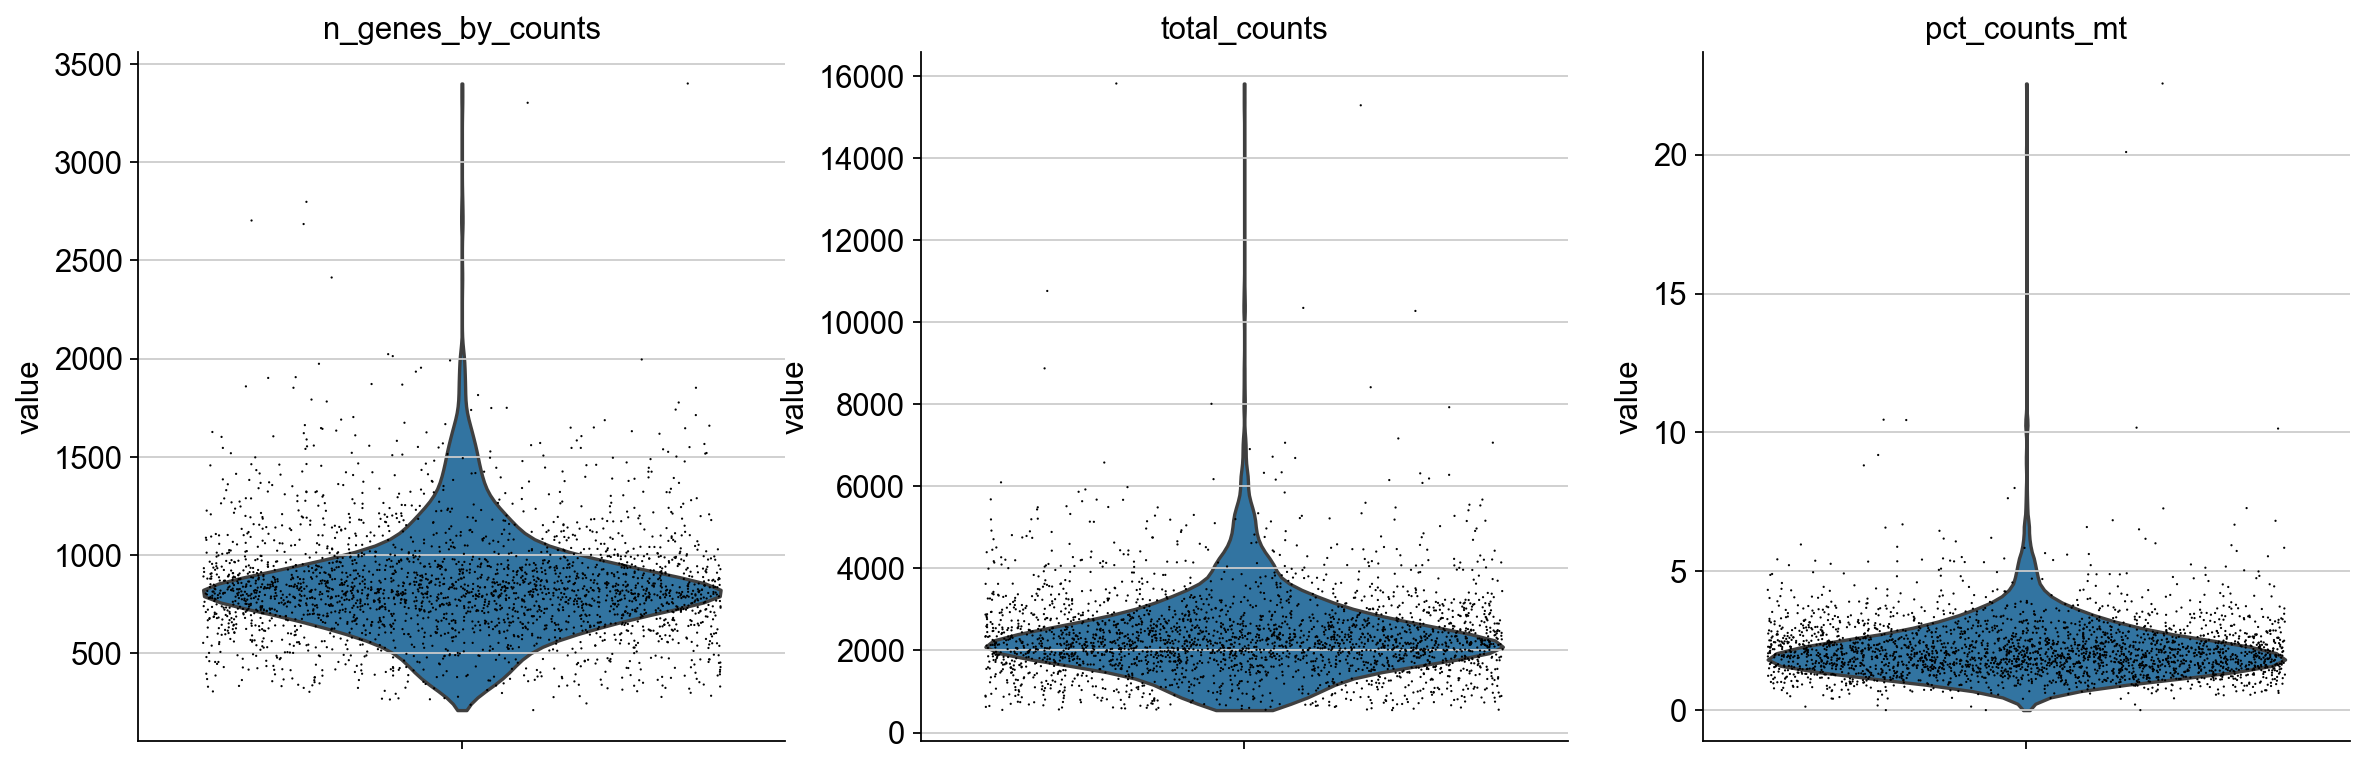

In [7]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

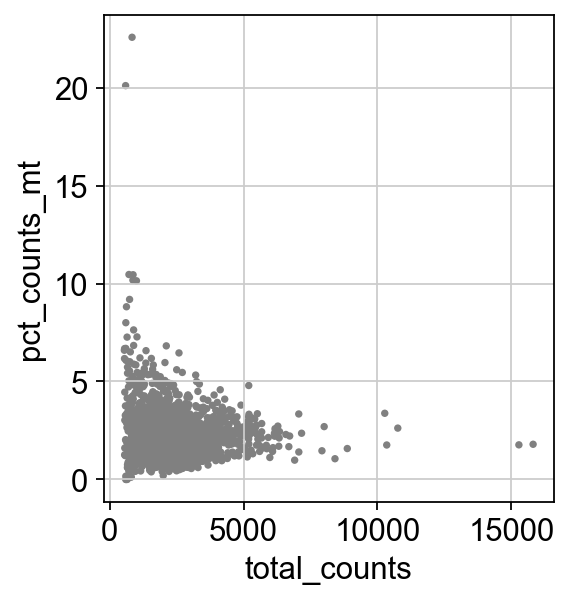

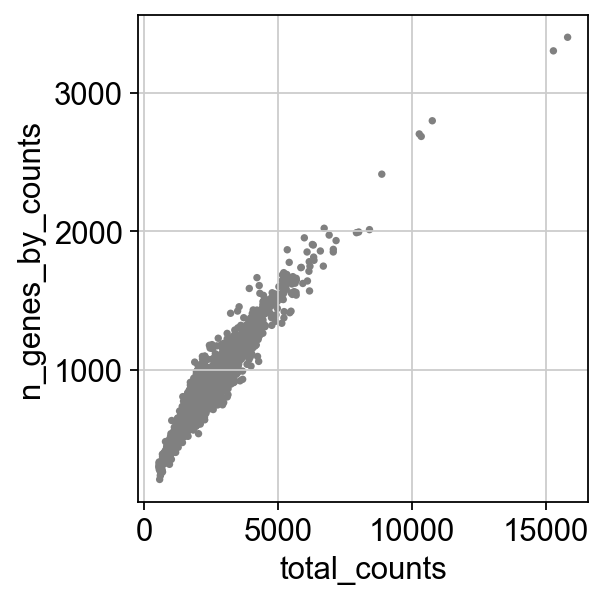

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Filtering

In [9]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [10]:
#making copy to keep unnormalized:
adata_copy = adata.copy()

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


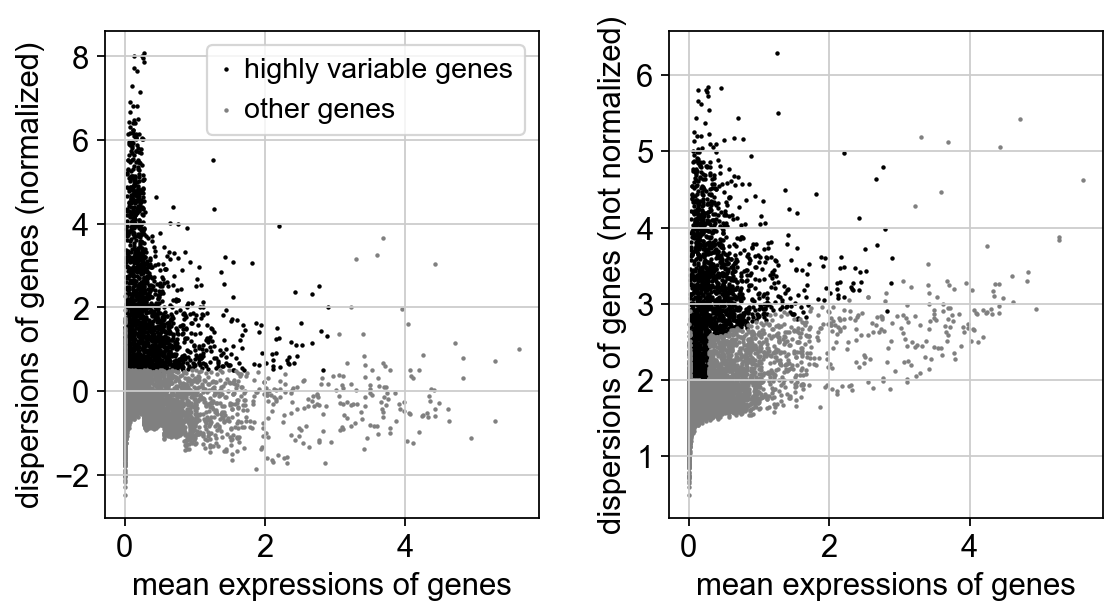

In [11]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)


In [12]:
# now process the counts further and filtering
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:14)


PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


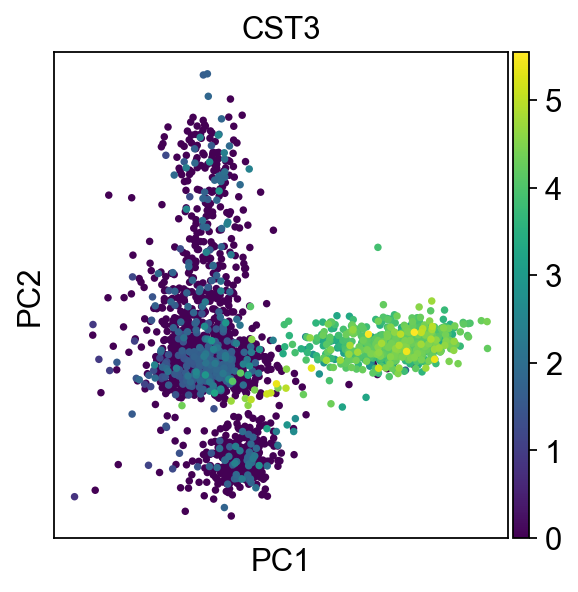

In [13]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

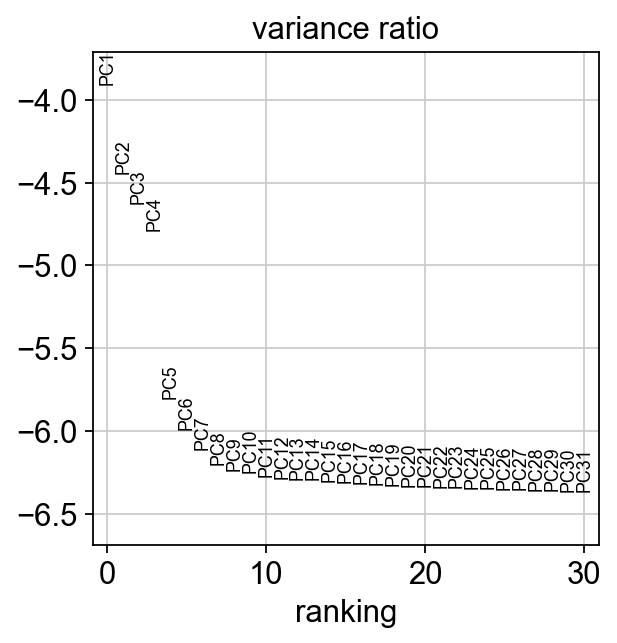

In [14]:
sc.pl.pca_variance_ratio(adata, log=True)

Compute and embedd neighborhood graph

In [15]:
# calculate neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


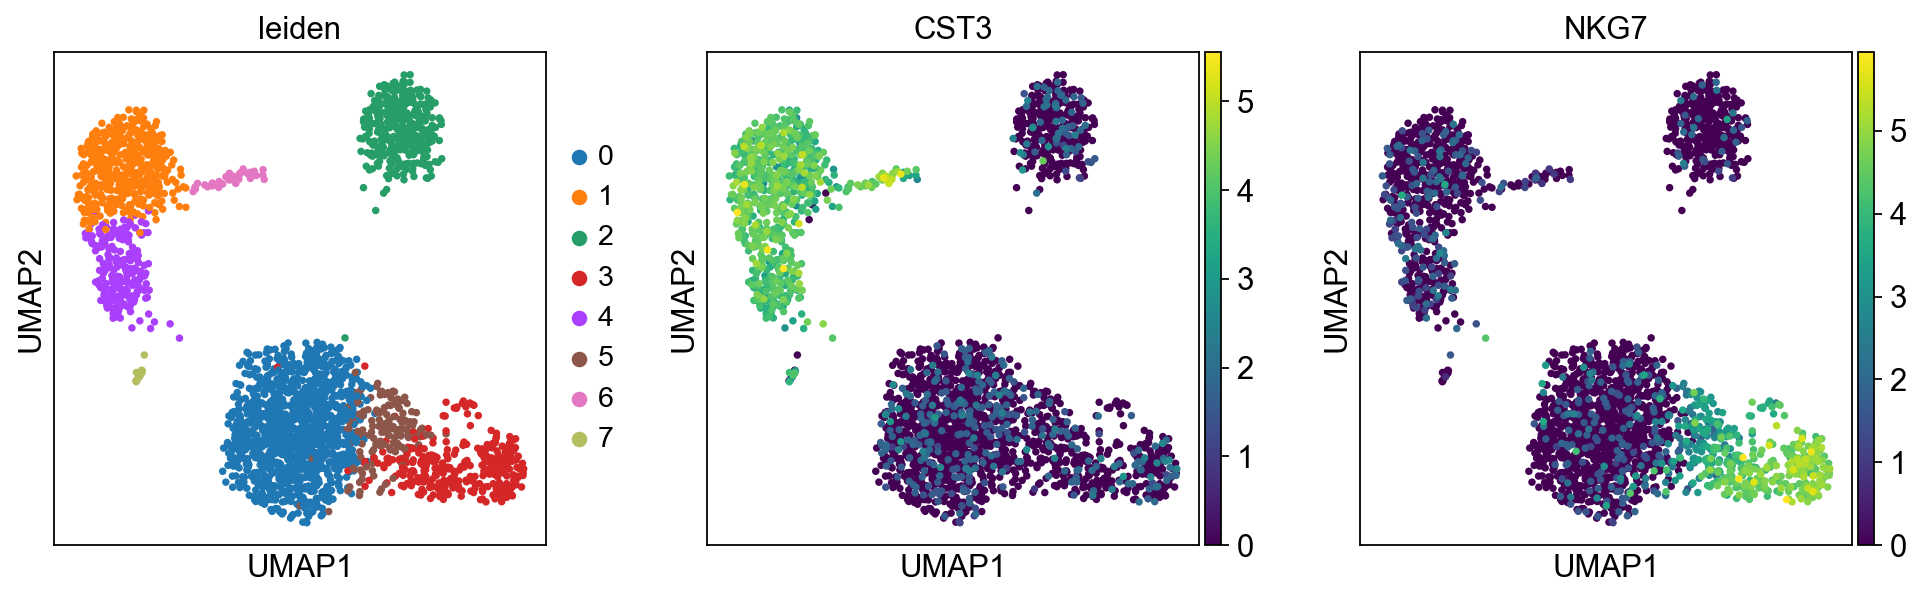

In [16]:
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Finding Marker Genes:

In [17]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:01)


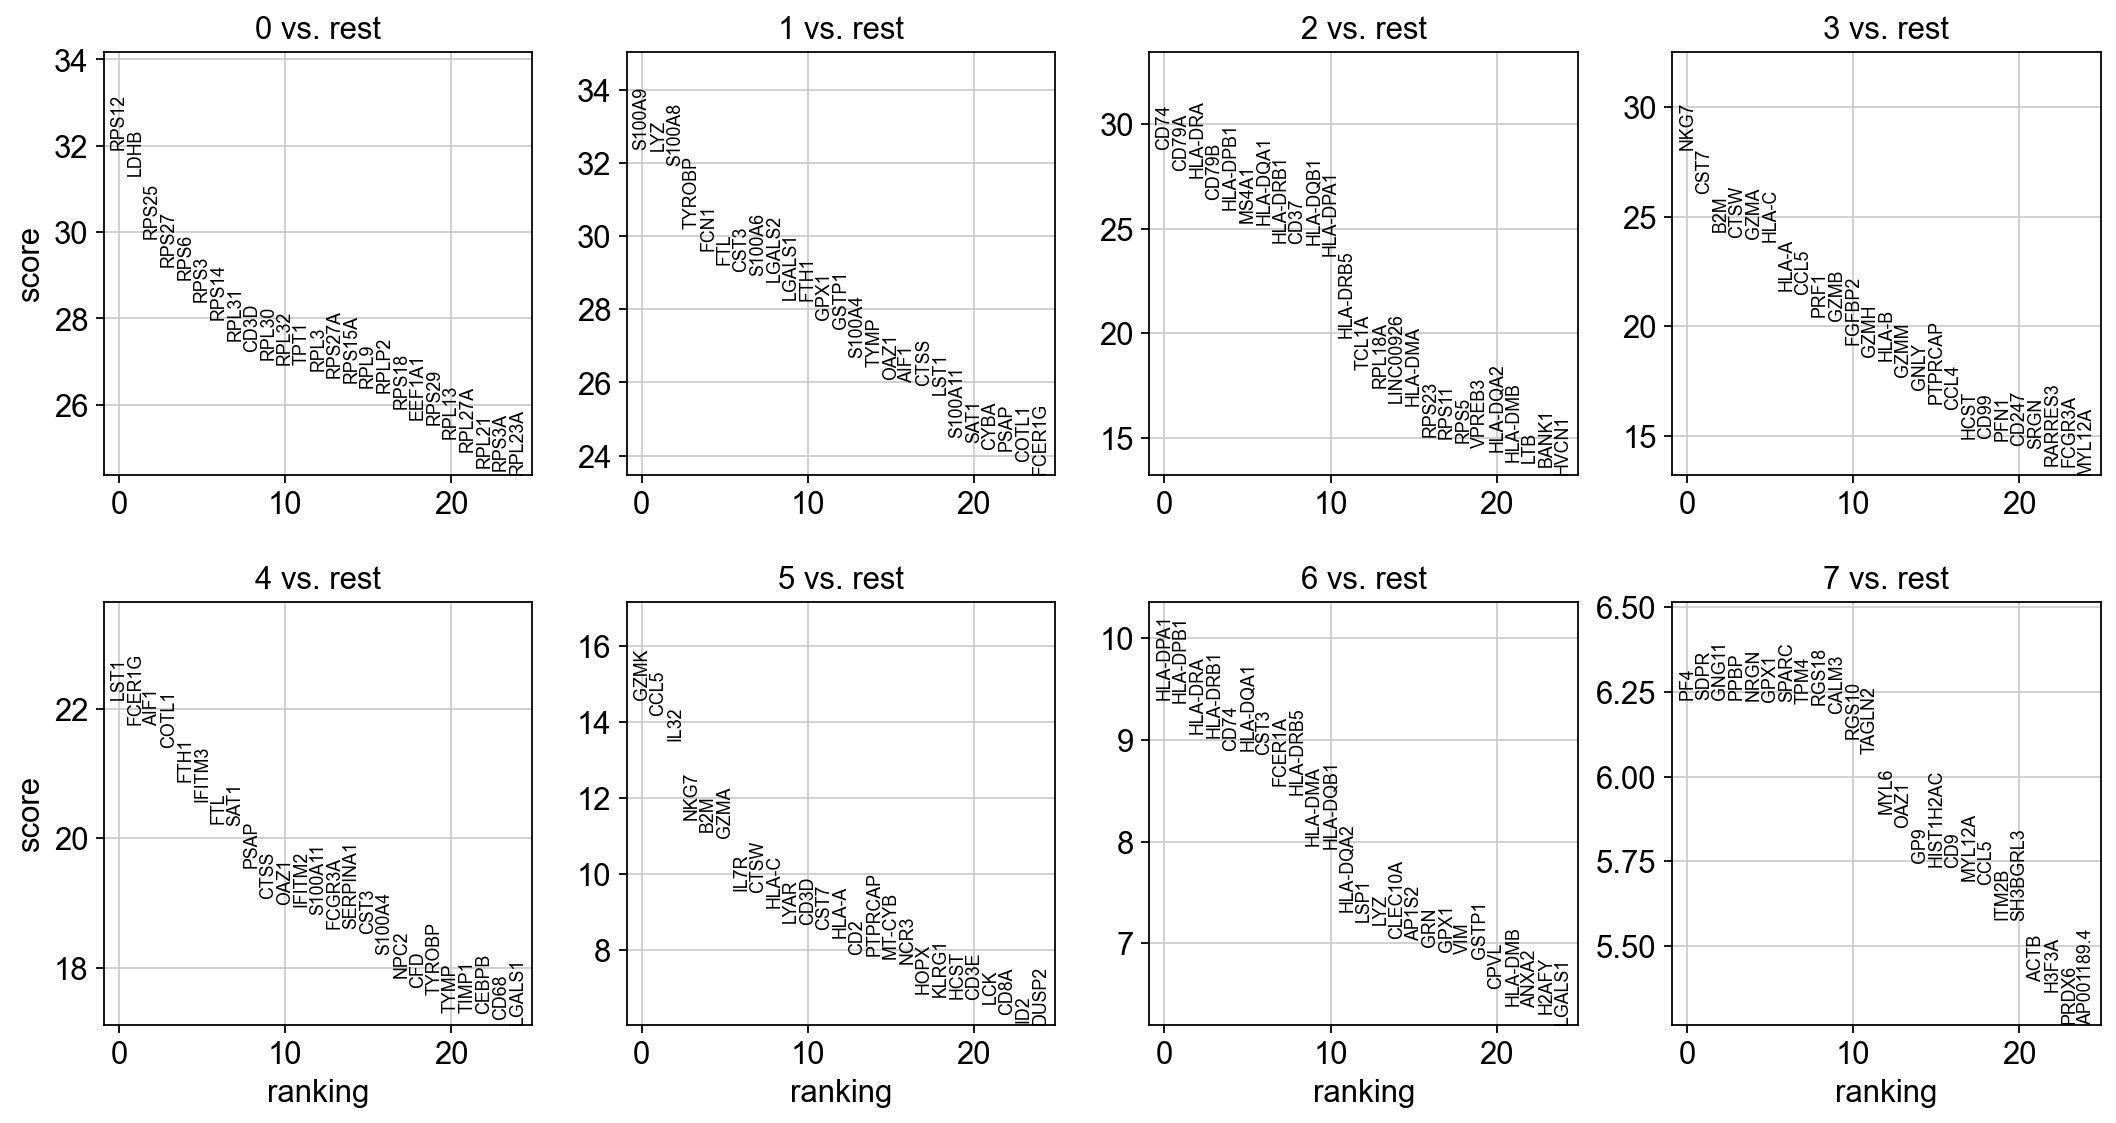

In [18]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:00:02)


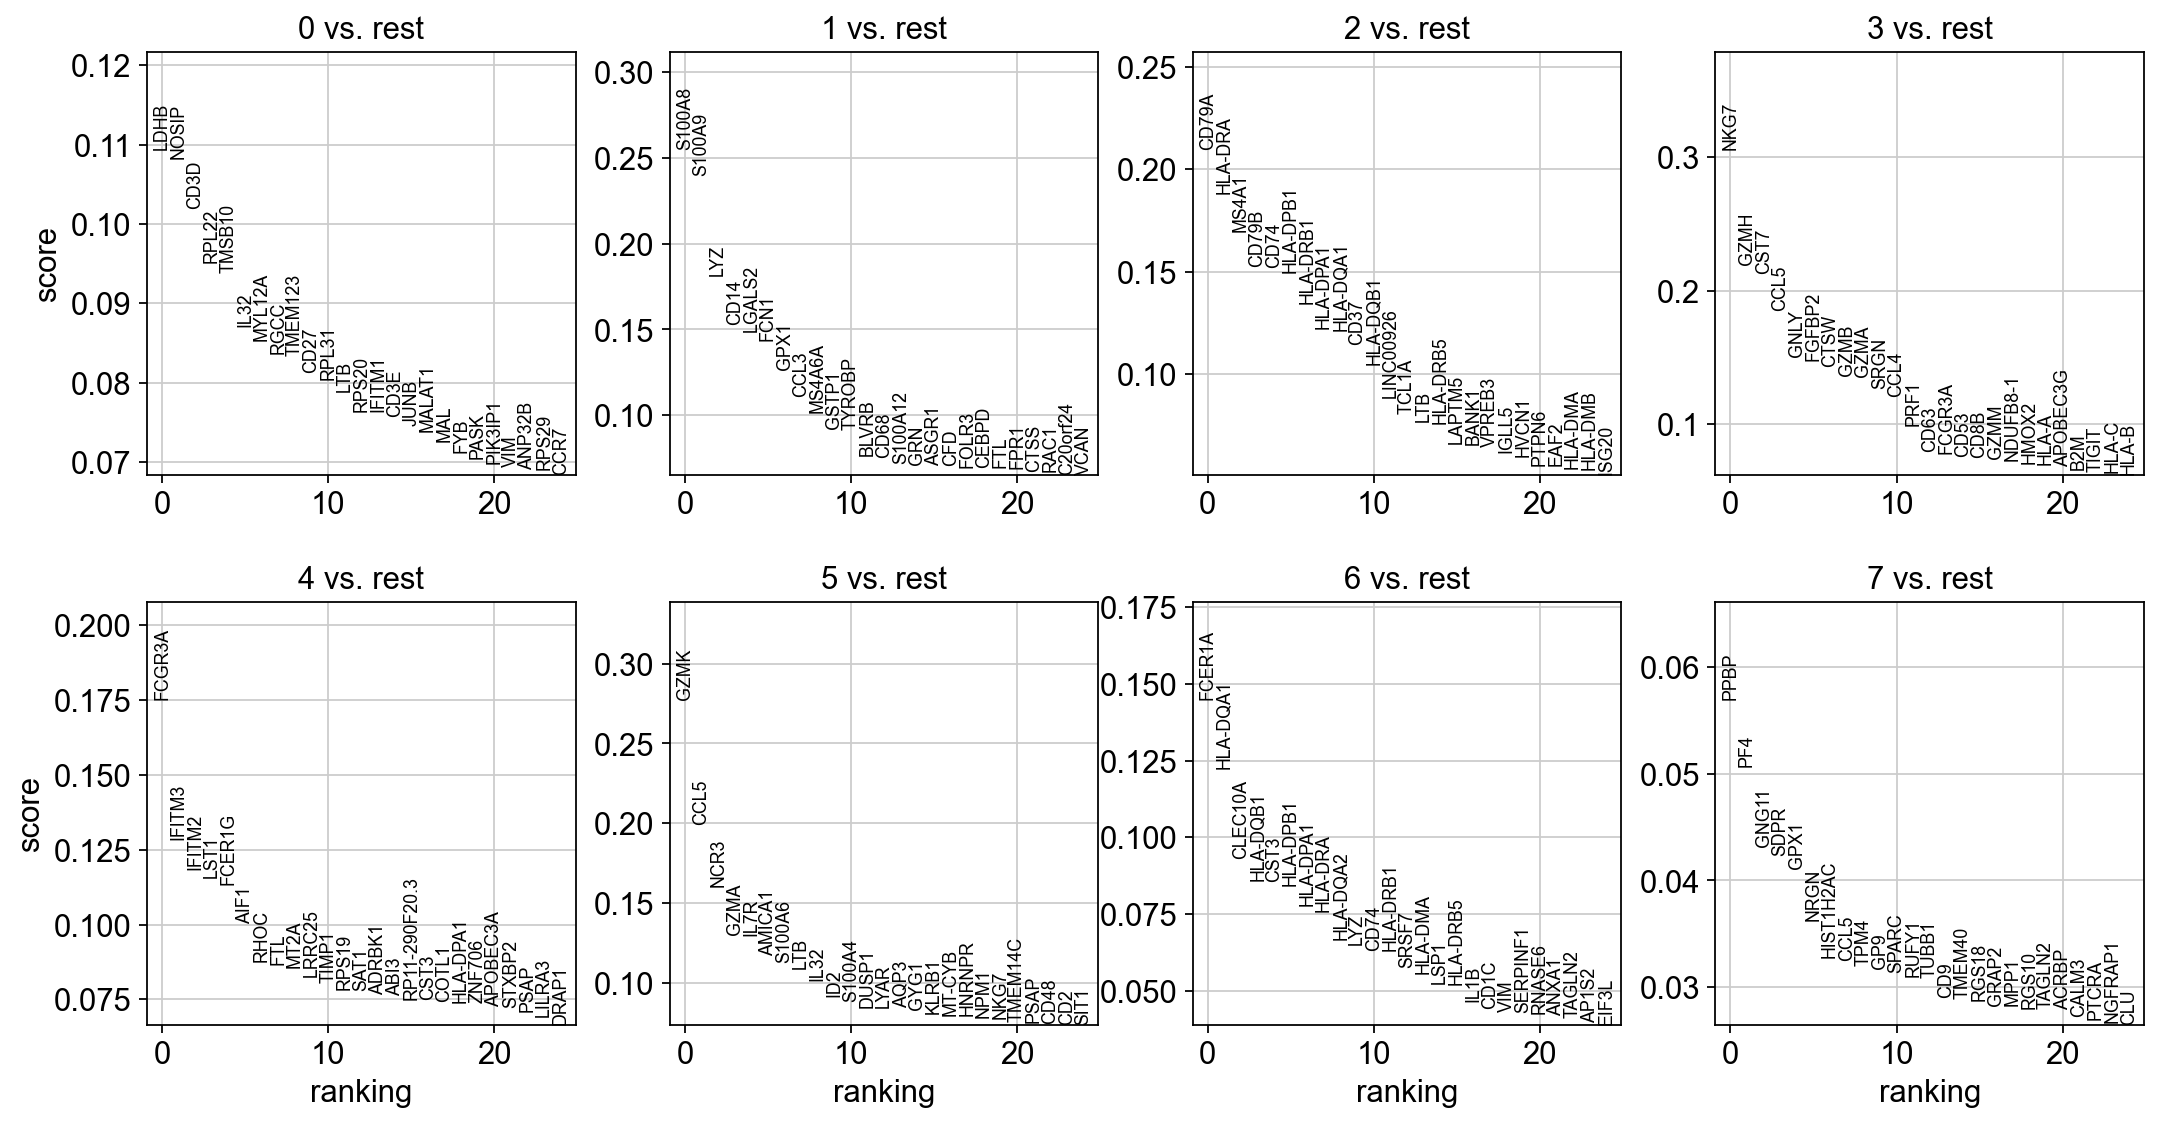

In [19]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [20]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [21]:
#recovering unnormalized anndata
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1        2     3       4     5         6      7
0    LDHB  S100A8    CD79A  NKG7  FCGR3A  GZMK    FCER1A   PPBP
1   NOSIP  S100A9  HLA-DRA  GZMH  IFITM3  CCL5  HLA-DQA1    PF4
2    CD3D     LYZ    MS4A1  CST7  IFITM2  NCR3   CLEC10A  GNG11
3   RPL22    CD14    CD79B  CCL5    LST1  GZMA  HLA-DQB1   SDPR
4  TMSB10  LGALS2     CD74  GNLY  FCER1G  IL7R      CST3   GPX1

Get a table with the scores and groups.

ranking genes
    finished (0:00:00)


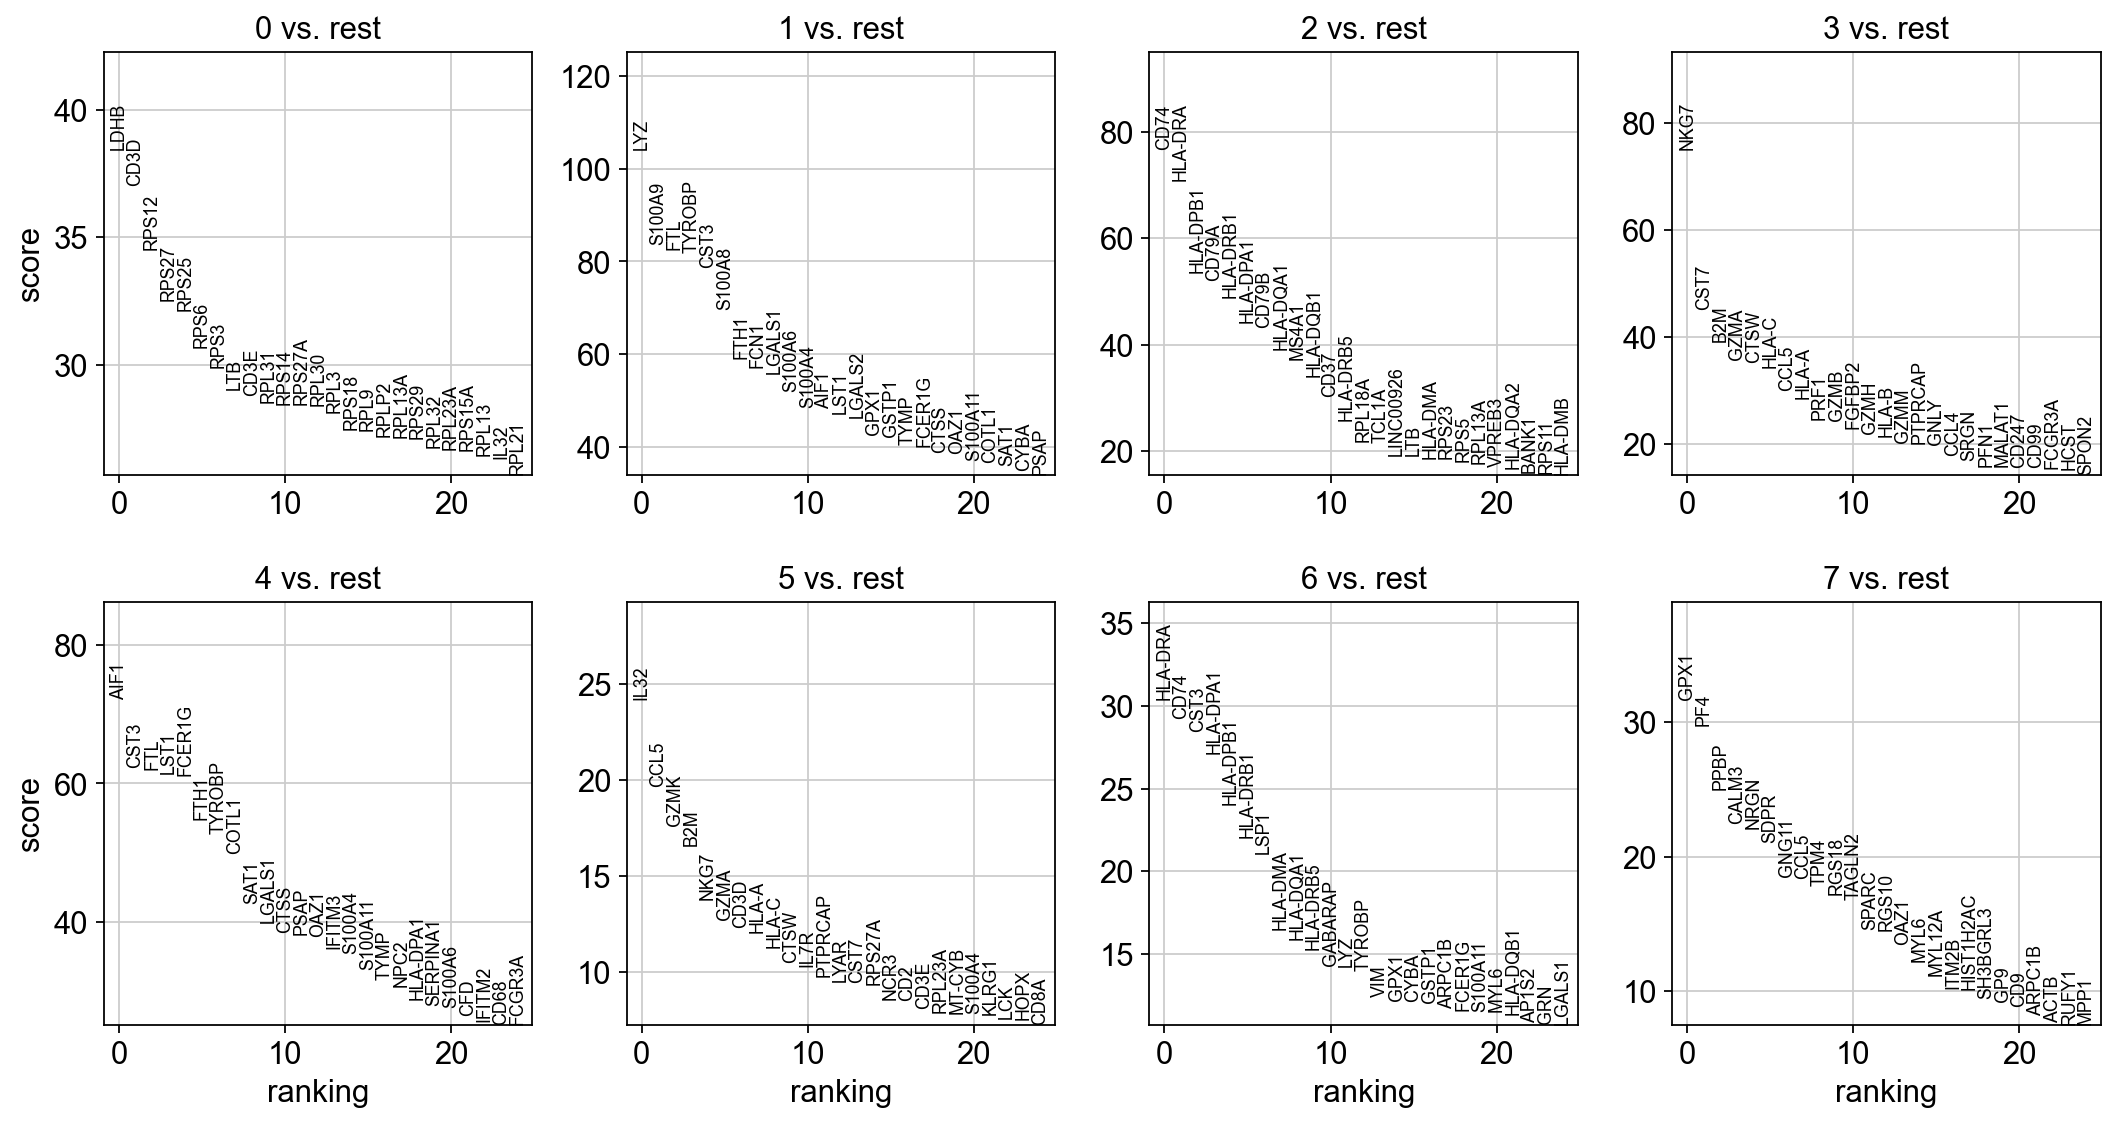

In [22]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [23]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n  1_p       2_n            2_p   3_n  \
0   LDHB  6.738307e-257     LYZ  0.0      CD74   0.000000e+00  NKG7   
1   CD3D  5.434050e-241  S100A9  0.0   HLA-DRA   0.000000e+00  CST7   
2  RPS12  2.296645e-211     FTL  0.0  HLA-DPB1  2.421135e-269   B2M   
3  RPS27  7.361989e-192  TYROBP  0.0     CD79A  4.944394e-168  GZMA   
4  RPS25  1.641513e-188    CST3  0.0  HLA-DRB1  8.957978e-242  CTSW   

             3_p     4_n            4_p   5_n           5_p       6_n  \
0  1.812316e-244    AIF1  3.061068e-293  IL32  1.001296e-66   HLA-DRA   
1  1.085852e-147    CST3  1.845477e-290  CCL5  2.541176e-47      CD74   
2  8.506920e-165     FTL  3.724761e-268  GZMK  4.643399e-40      CST3   
3  7.737807e-119    LST1  4.555887e-193   B2M  8.697694e-42  HLA-DPA1   
4  8.942505e-121  FCER1G  8.138363e-210  NKG7  1.728441e-30  HLA-DPB1   

            6_p    7_n           7_p  
0  6.560267e-32   GPX1  1.326433e-13  
1  2.552722e-31    PF4  1.251720e-12  
2  2.601737e-29   PPBP  9.925949e-12  
3  4.913539e-28  CALM3  1.688225e-11  
4  2.866570e-25   NRGN  4.092874e-11

Compare to a single cluster:

ranking genes
    finished (0:00:00)


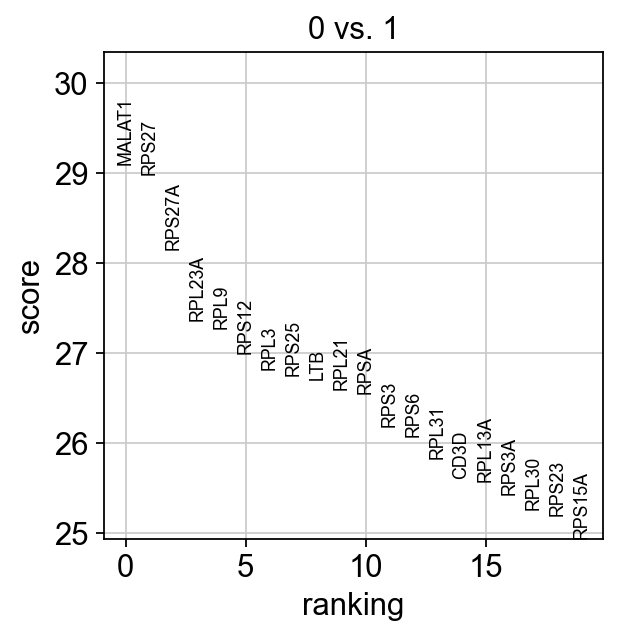

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

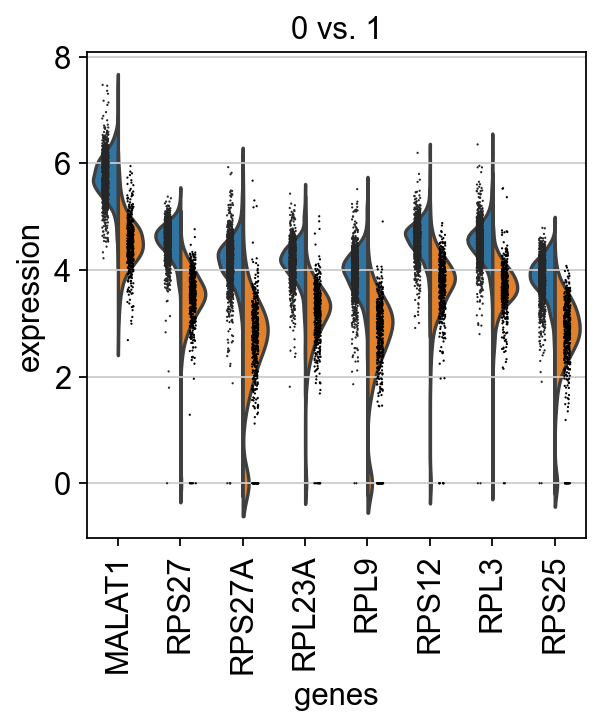

In [25]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

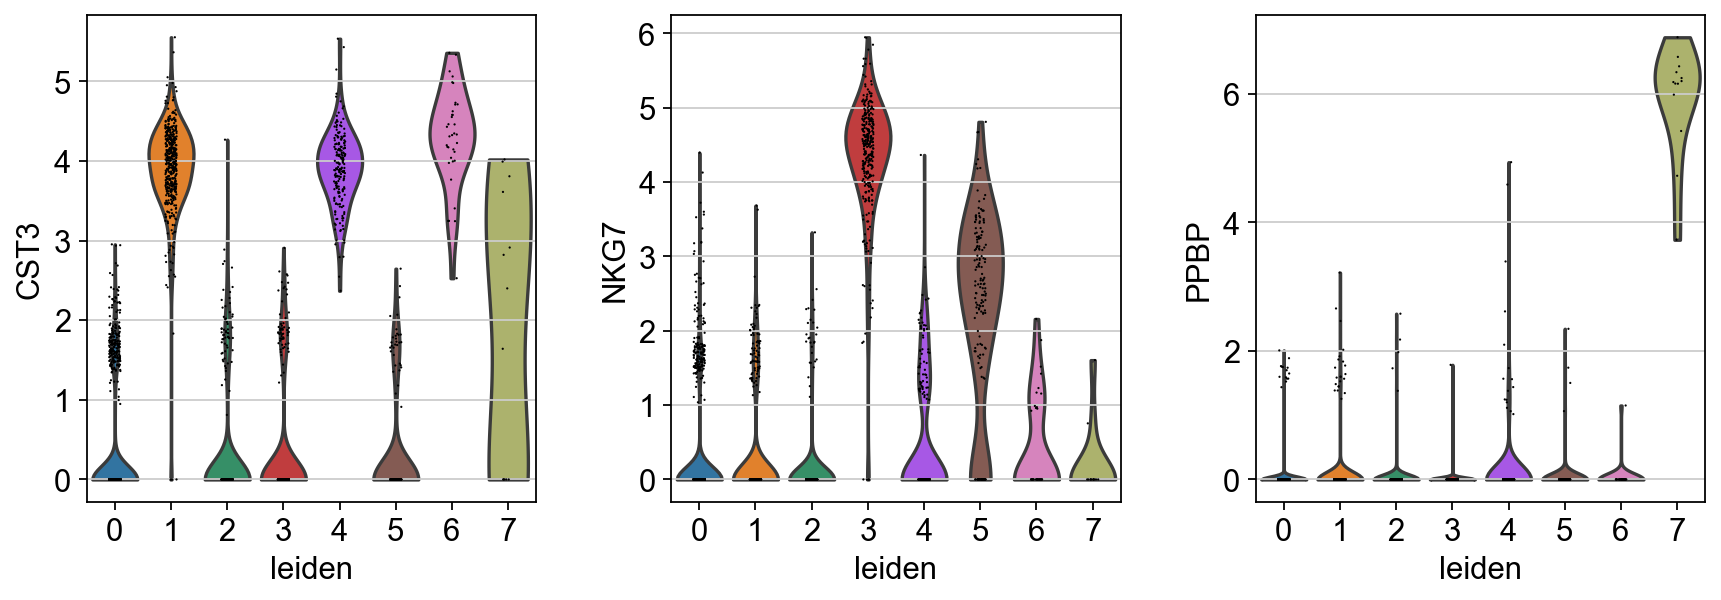

In [26]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

In [27]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


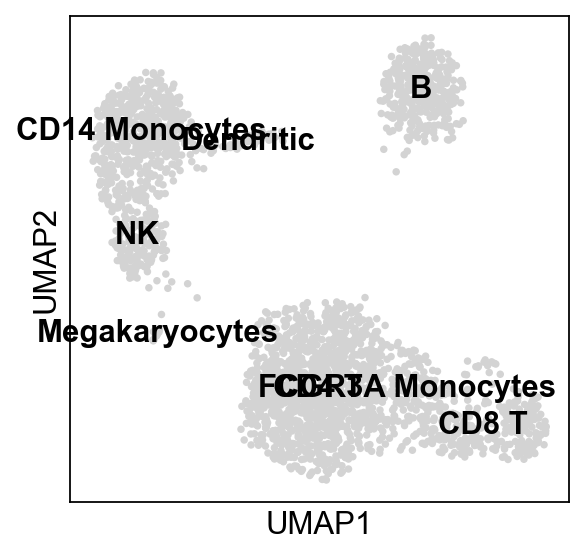

In [28]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='')

Now that we annotated the cell types, let us visualize the marker genes.

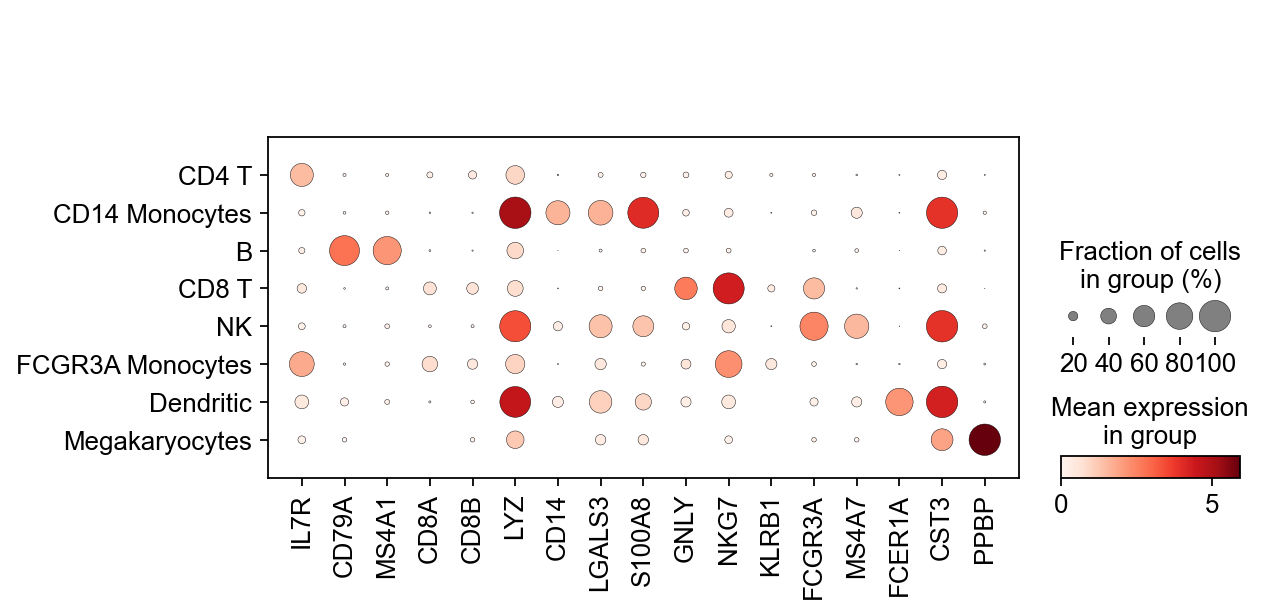

In [29]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

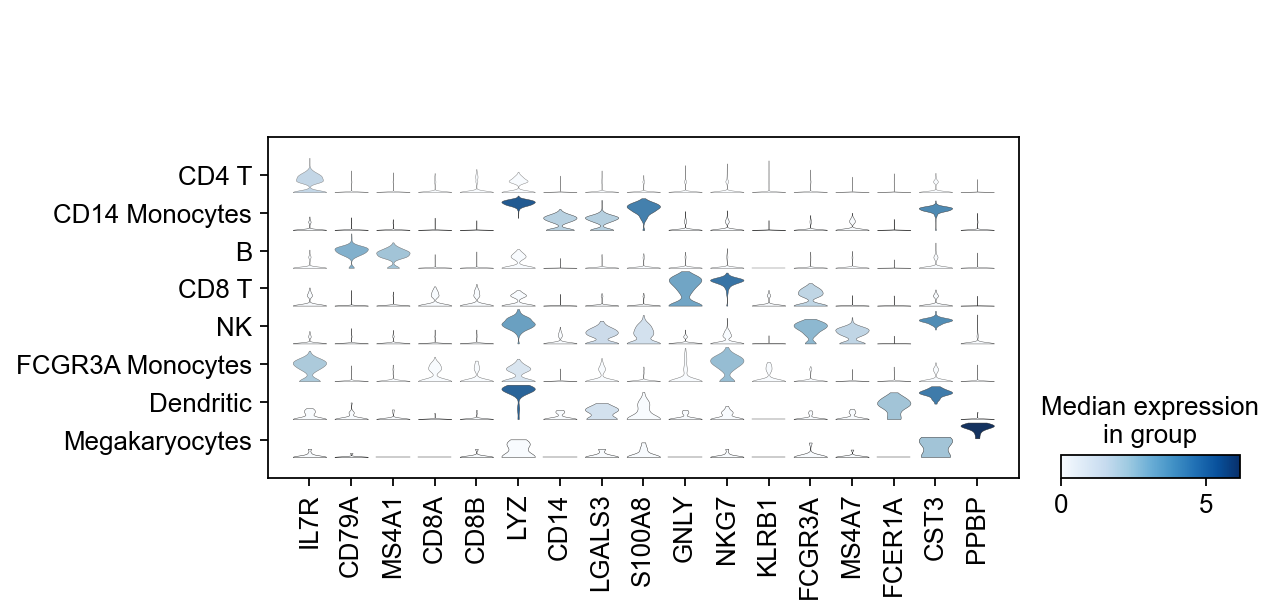

In [30]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

Assigning cell types to unnormalized adata:

In [31]:
adata_copy.obs["cell_types"] = adata.obs["leiden"]
adata_copy.obs["scpred_CellType"] = adata.obs["leiden"]

In [32]:
#normalized
adata.X.max()

10.0

In [33]:
#unnormalized
adata_copy.X.max()

419.0

In [34]:
#and swithcing to only using adata without normalization
adata = adata_copy

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
running PAGA
    finished (0:00:00)
computing UMAP
    finished (0:00:03)


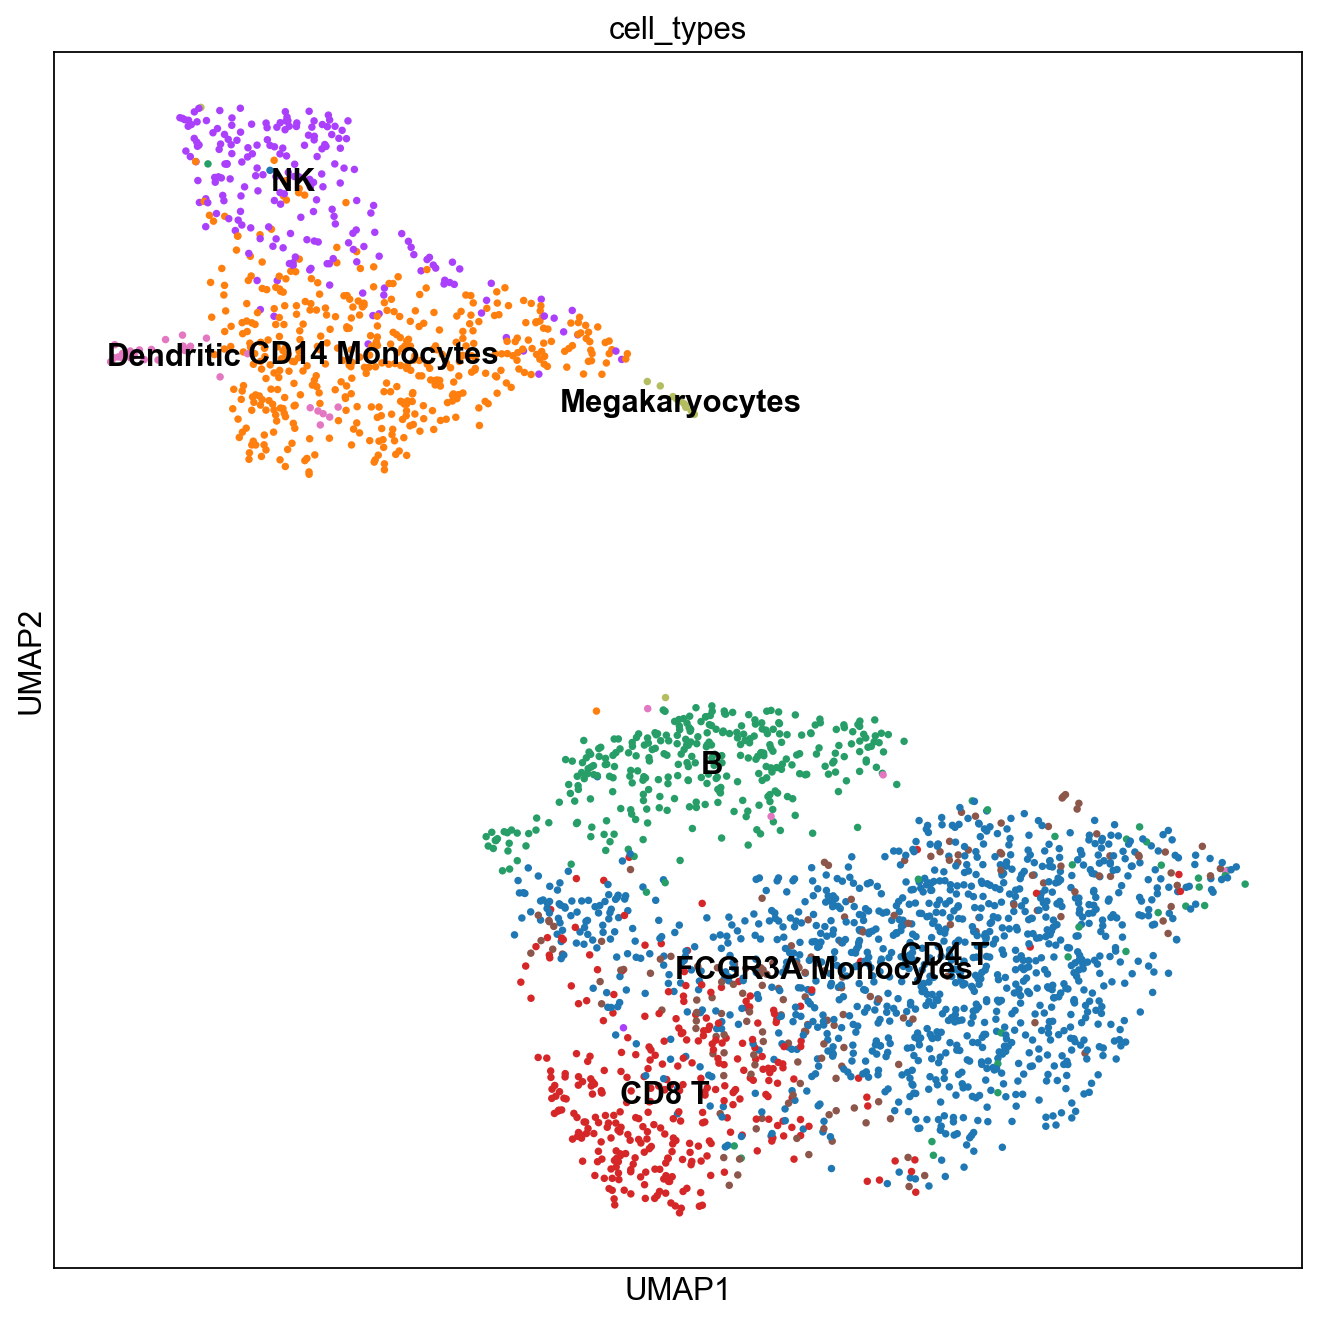

In [35]:
# lets see Leiden clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution=0.7)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='cell_types', legend_loc='on data')

As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [36]:
Counter(adata.obs["scpred_CellType"])

Counter({'FCGR3A Monocytes': 163,
         'B': 342,
         'CD4 T': 1131,
         'NK': 200,
         'CD8 T': 317,
         'CD14 Monocytes': 436,
         'Dendritic': 36,
         'Megakaryocytes': 13})

In [37]:
# remove cells that are unlabeled or unclassified
cell_type_id = adata.obs["scpred_CellType"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Dendritic", "Megakaryocytes"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["scpred_CellType"].isin(cell_type_id)]
#matching obs
adata.obs["cell_types"] = adata.obs["scpred_CellType"]
print(np.unique(adata.obs["scpred_CellType"].values))

Trying to set attribute `.obs` of view, copying.


['B' 'CD14 Monocytes' 'CD4 T' 'CD8 T' 'FCGR3A Monocytes' 'NK']


Visualize cell types:

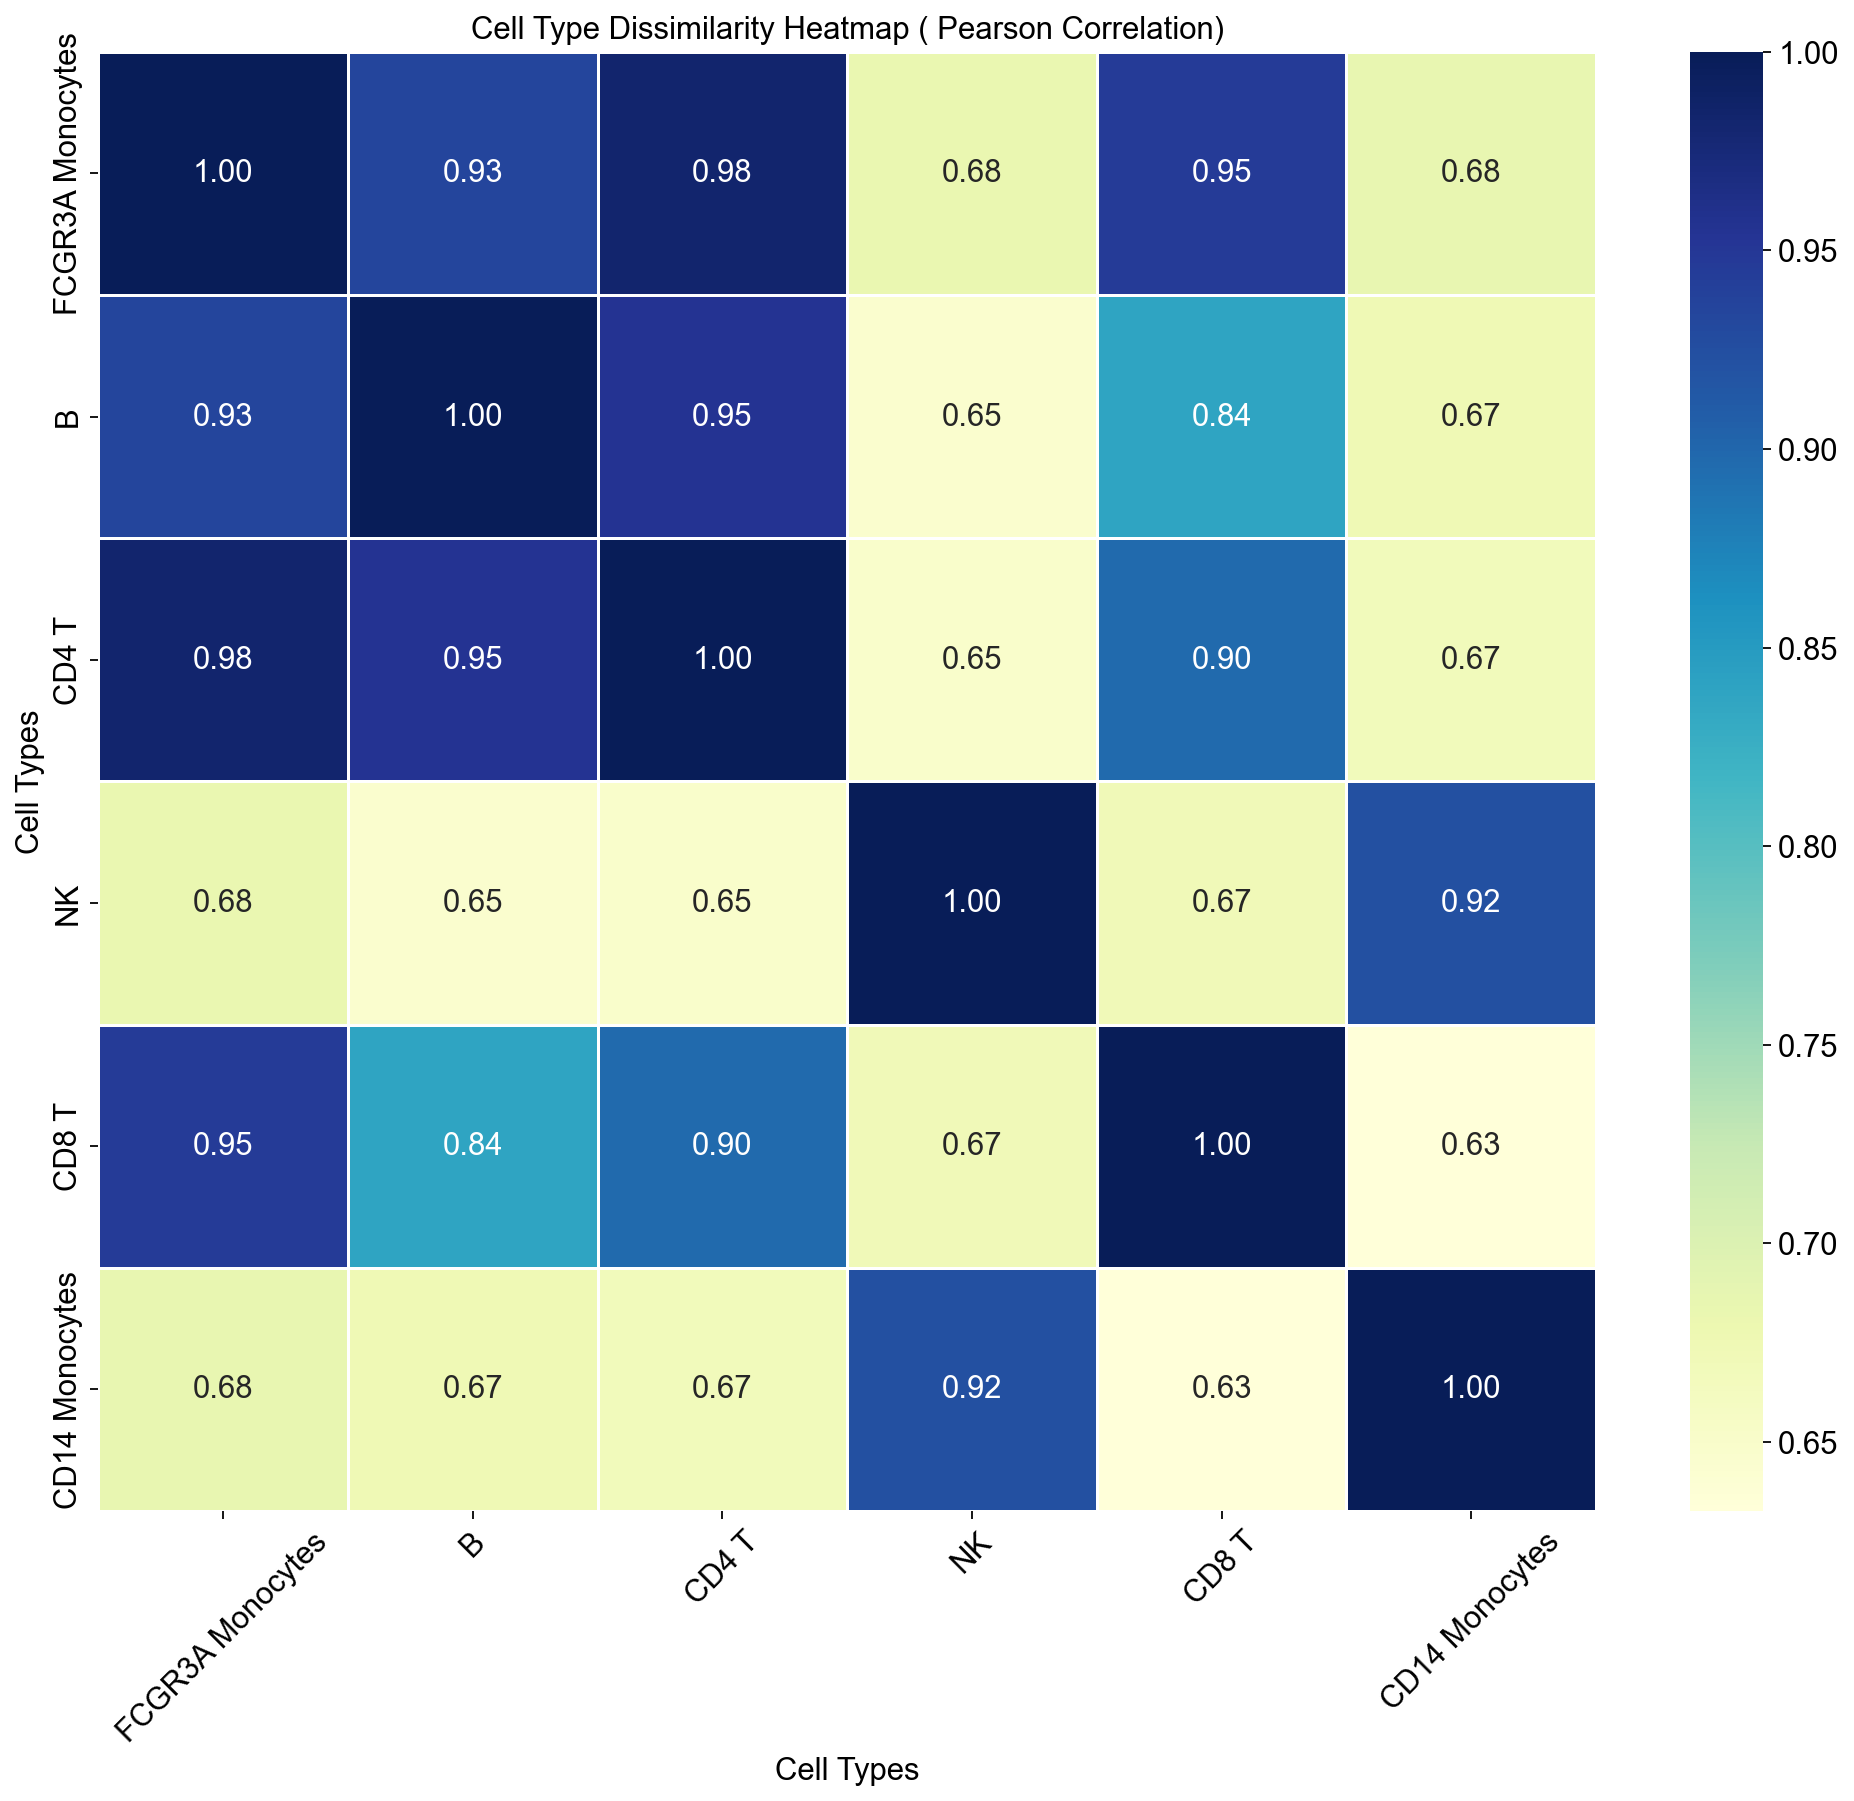

In [38]:
# Define the number of samples for resampling
num_samples = 5000

# Making cell type reference without scaling
cell_types = adata.obs["cell_types"].unique()
gene_ids = adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

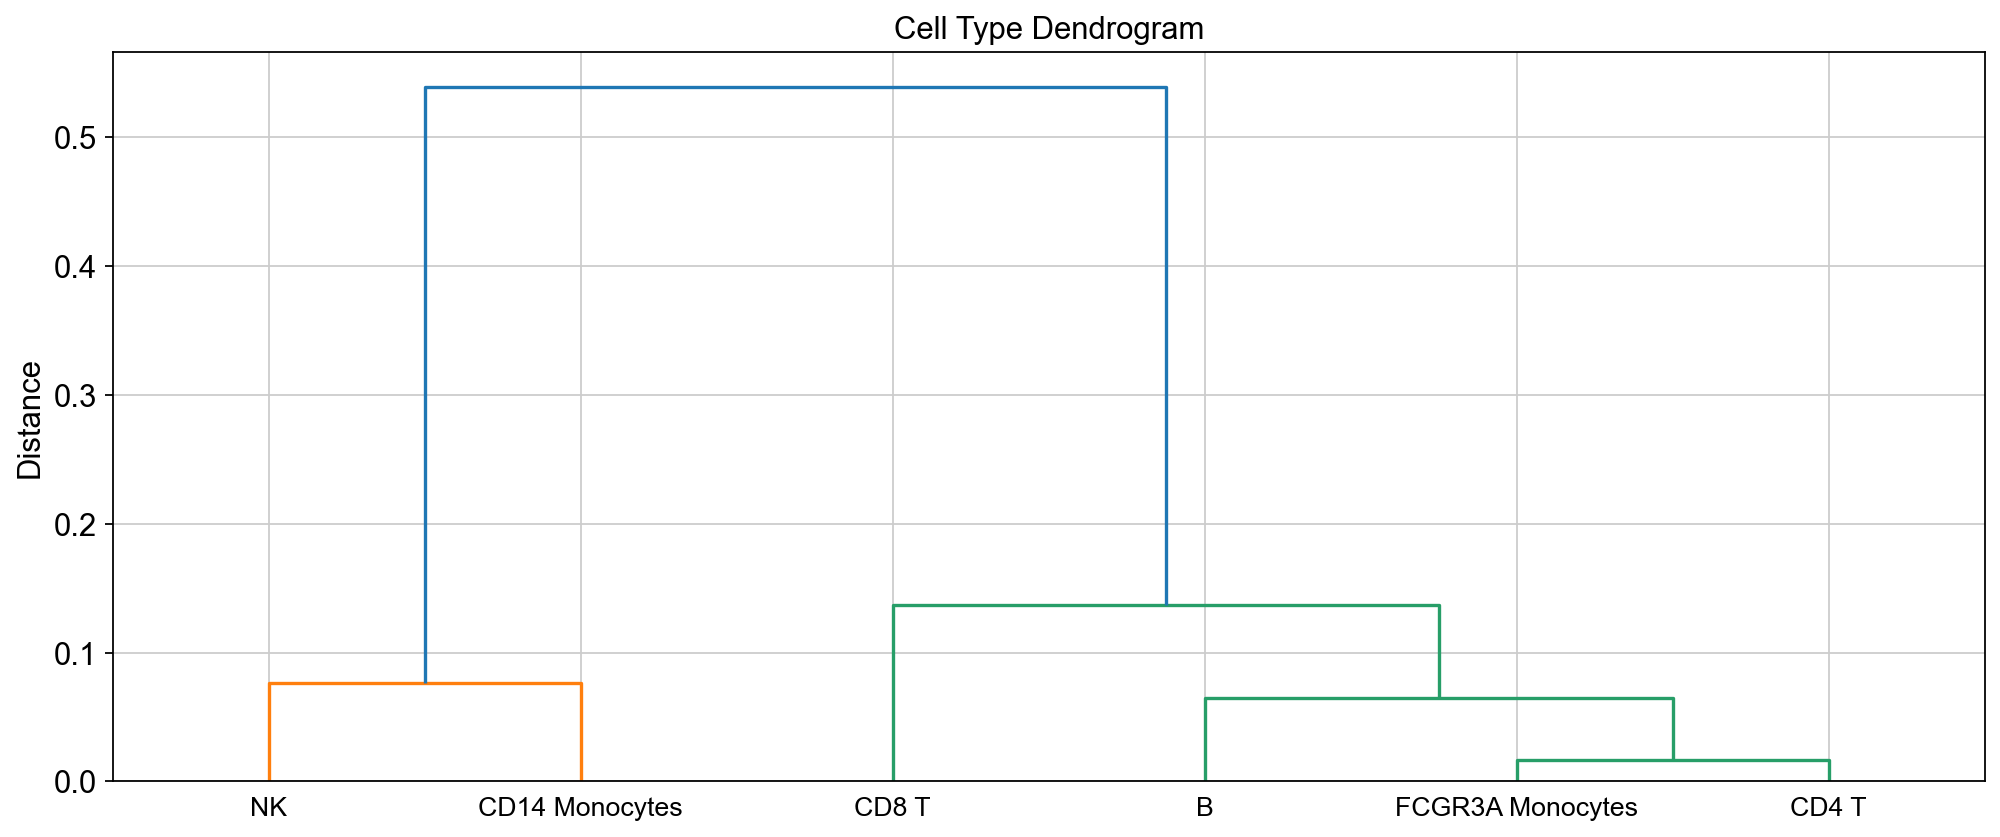

In [39]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

In [40]:
#saving for later adata as anndata without normalization
adata_path_ = os.path.join(adata_path, f"{res_name}_adata_notlog.h5ad")
adata_path_ = Path(adata_path_)
adata.write_h5ad(adata_path_)

In [41]:
adata

AnnData object with n_obs × n_vars = 2589 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'scpred_CellType', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'cell_types_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

Interesection File:

In [42]:
# write out the gene ids in intersection file
genes_all = adata.var["gene_ids"]
gene_out_file = os.path.join(aug_data_path, f"{res_name}intersection_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( genes_all, open(gene_out_path, "wb" ) )

## **Pseudobulk-creating loops:**
1. All Cell Types, Noise added
2. All Cell Types, No noise added

Run all or one at a time as needed.

In [43]:
#assigning cell types to untransformed data
sn_adata = adata.copy()
Counter(sn_adata.obs["scpred_CellType"])

Counter({'FCGR3A Monocytes': 163,
         'B': 342,
         'CD4 T': 1131,
         'NK': 200,
         'CD8 T': 317,
         'CD14 Monocytes': 436})

In [44]:
# no specific cell noise 
len_vector = sn_adata.obs["cell_types"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, sn_adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = sn_adata.obs.cell_types.unique()
num_random = 200 #number of random pseudos

#adding cell types to both
sn_adata.obs['scpred_CellType'] = sn_adata.obs["cell_types"] #to match var name in functions
#custom proportion of equal prop / cell
num_cells = len_vector
custom_prop = np.array([(1/num_cells)]*num_cells)
custom_prop  =  pd.DataFrame(custom_prop).T
custom_prop.columns = cell_order
custom_prop

FCGR3A Monocytes         B     CD4 T        NK     CD8 T  CD14 Monocytes
0          0.166667  0.166667  0.166667  0.166667  0.166667        0.166667

All Cell Types, No Noise:

In [45]:
sampling_adata = sn_adata
num_cells = 5000
num_random = 200
noise_type = "No noise" #to create noise
sample_noise = None
if make_pseudos:  
        for idx in range(0,10):
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type = noise_type)

                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise, noise_type = noise_type)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type = noise_type)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_nonoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_nonoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

All Cell Types, Noise:

In [46]:
sampling_adata = sn_adata
num_cells = 5000
num_random = 200
noise_type = "No sample noise"
sample_noise = None
if make_pseudos:  
        for idx in range(0,10):
                noise_type = "No sample noise"
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the real cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type=noise_type)

                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise, noise_type=noise_type)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type=noise_type)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_noise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_noise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

**QC Pseudobulks Made:**

In [75]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

900

In [76]:
X_full, Y_full, gene_df, meta_df= sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path,
                noise_type= "nonoise_", file_name = res_name, num_bulks_training = num_bulks, 
                num_files=1, random_selection=False)

0


(900, 2)
(900, 2)


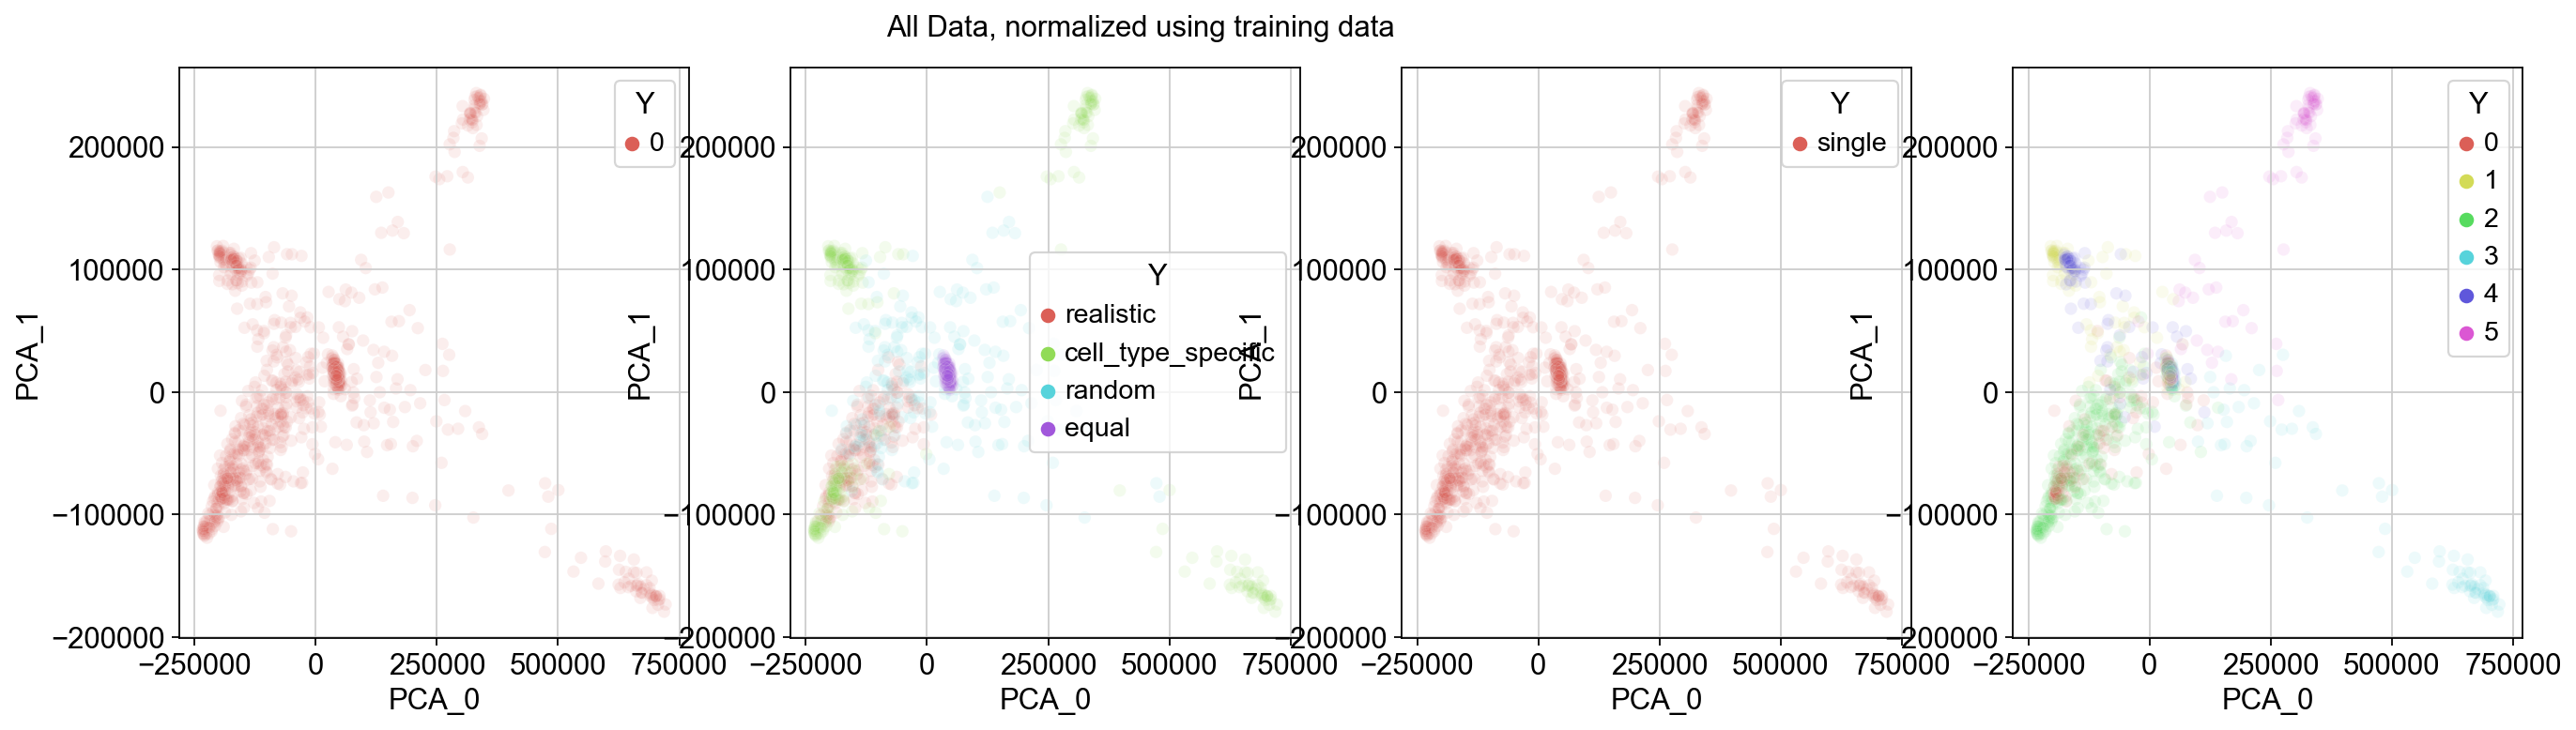

In [77]:
## plot samples
plot_df = vp.get_pca_for_plotting(X_full)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 900 samples in 0.003s...
[t-SNE] Computed neighbors for 900 samples in 0.187s...
[t-SNE] Computed conditional probabilities for sample 900 / 900
[t-SNE] Mean sigma: 6574.042826
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.471794
[t-SNE] KL divergence after 500 iterations: 0.465087
(900, 2)
(900, 2)


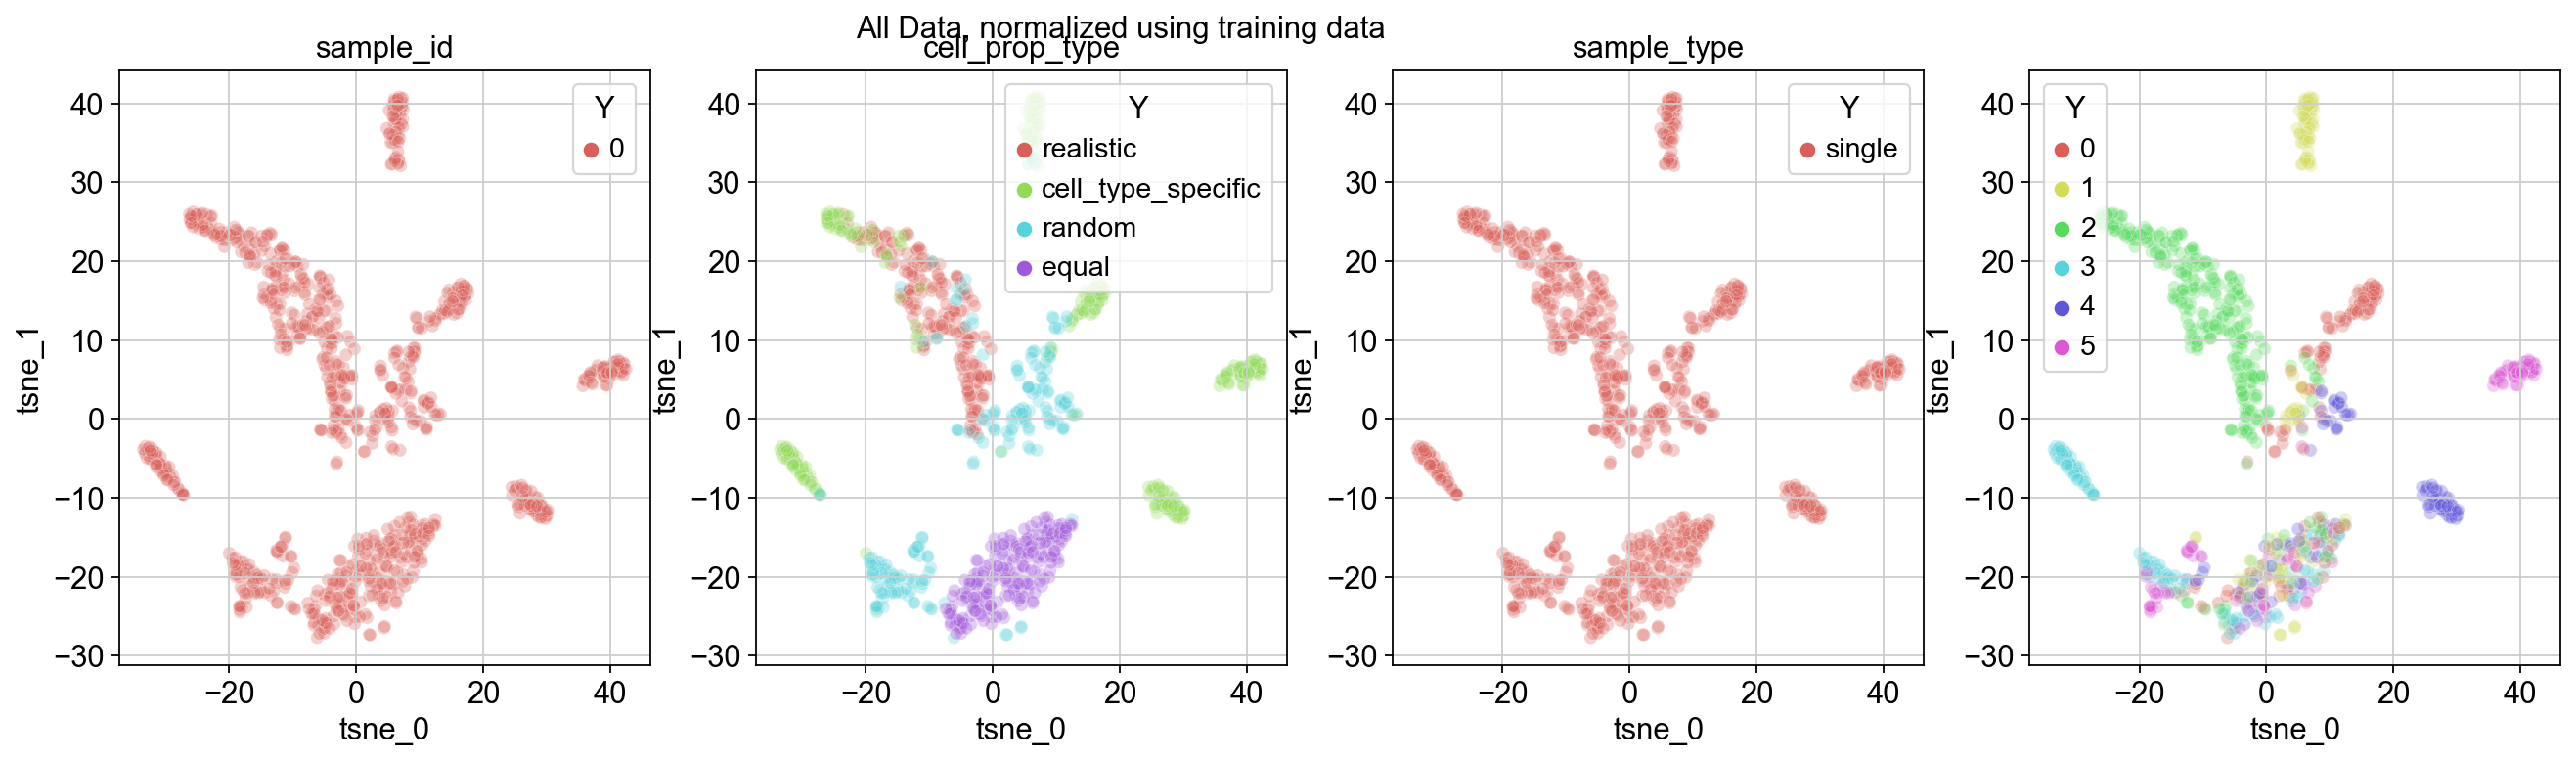

In [78]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

## **CibersortX Preparation:**
This is run to get the cell specific barcode genes from CIBERSORTx.

In [79]:
if prep_cibersort:
    #and as anndata object
    adata_path_ = os.path.join(adata_path, f"{res_name}_adata_notlog.h5ad")
    print(adata_path_)
    adata_path_ = Path(adata_path_)
    sn_adata_copy = sc.read_h5ad(adata_path_)
    print(Counter(sn_adata_copy.obs.cell_types))

/Users/ivicha/Documents/Project_missingcelltype/pred_missing_celltypes/preprocessing/../data/MCT_pbmc_EXP1_adata_notlog.h5ad
Counter({'CD4 T': 1131, 'CD14 Monocytes': 436, 'B': 342, 'CD8 T': 317, 'NK': 200, 'FCGR3A Monocytes': 163})


Deleting cells in large cell types to be able to run CibersortX:
(data is too large)

In [80]:
if prep_cibersort:
    if limit_celltypes:

        #dreate a mask to identify cells from the cell types to limit
        mask_to_limit = sn_adata_copy.obs["cell_types"].isin(cell_types_to_limit)

        #create a mask for the remaining cell types
        mask_remaining = ~mask_to_limit

        #initialize a dictionary to keep track of removed cells per cell type
        removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

        #initialize arrays to store new observations and filtered indices
        new_obs = []
        filtered_indices = []

        #iterate through each cell in the original sn_adata object
        for cell_idx, cell_type in enumerate(sn_adata_copy.obs["cell_types"]):
            if cell_type in cell_types_to_limit:
                removed_count = removed_cells_count.get(cell_type, 0)
                if removed_count < max_cells_per_type:
                    removed_cells_count[cell_type] = removed_count + 1
                    filtered_indices.append(cell_idx)

        #create a new AnnData object with the filtered cells
        filtered_sn_adata = sc.AnnData(
            X=sn_adata_copy.X[filtered_indices],
            obs=sn_adata_copy.obs.iloc[filtered_indices],
            var=sn_adata_copy.var
        )

        #cppend the remaining cell types to the filtered sn_adata object
        filtered_sn_adata = filtered_sn_adata.concatenate(
            sn_adata_copy[mask_remaining],
            join="outer"
        )
        #QC
        print(Counter(filtered_sn_adata.obs.cell_types))

In [81]:
if limit_celltypes:
    sn_adata_copy = filtered_sn_adata.copy()

In [82]:
if prep_cibersort:
    dense_matrix = sn_adata_copy.X.todense()

    sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
    sc_profile_path = Path(sc_profile_file)

    dense_df = pd.DataFrame(dense_matrix, columns = sn_adata_copy.var_names)
    dense_df.insert(loc=0, column='cell_types', value=sn_adata_copy.obs["cell_types"].to_list())
    #save file
    pickle.dump( dense_df, open( sc_profile_path, "wb" ) )
    #qc
    sig_df_sn = dense_df
    sig_df_sn.shape

    X_full.columns = sn_adata_copy.var_names

In [83]:
if prep_cibersort:
    #cut to only the random samples
    X_full.index = meta_df.index
    # # now we import all bulks and transpose
    X_train = X_full.transpose()
    X_train.columns = range(X_train.shape[1])

In [84]:
if prep_cibersort:
    #details
    exp_id = f"{res_name}"
    patient_idx =f"0"
    #and create files for CIBERSORTX
    mix_sn, sig_sn = sn_sc_preprocess.write_cs_bp_files(cibersort_path, exp_id, 
                        sig_df_sn, X_train, patient_idx)

Final files for CIBERSORTx QC:

In [85]:
mix_sn

0      1      2      3      4      5      6      7      8    \
AL627309.1      13.0   19.0   10.0   10.0   11.0   22.0   16.0   17.0   13.0   
AP006222.2       4.0    9.0    8.0    3.0    0.0    9.0    6.0    5.0    4.0   
RP11-206L10.2    8.0   10.0    4.0    7.0    2.0    7.0    4.0    5.0    4.0   
RP11-206L10.9    2.0    7.0    4.0    1.0    1.0   10.0    5.0    1.0    2.0   
LINC00115       32.0   29.0   35.0   30.0   36.0   36.0   28.0   36.0   35.0   
...              ...    ...    ...    ...    ...    ...    ...    ...    ...   
AC145212.1      23.0   25.0   17.0   14.0   26.0   32.0   37.0   32.0   21.0   
AL592183.1     729.0  655.0  680.0  667.0  665.0  684.0  679.0  705.0  694.0   
AL354822.1      19.0   17.0    8.0   12.0   15.0   11.0   18.0   14.0   10.0   
PNRC2-1        221.0  212.0  230.0  270.0  263.0  190.0  210.0  231.0  213.0   
SRSF10-1       150.0  112.0  160.0  161.0  165.0  135.0  140.0  140.0  147.0   

                 9    ...    890    891    892    893    894    895    896  \
AL627309.1      16.0  ...   15.0   12.0   11.0   13.0   22.0   19.0   15.0   
AP006222.2       8.0  ...    7.0    3.0    4.0    5.0    5.0    6.0    6.0   
RP11-206L10.2    5.0  ...    3.0    4.0    9.0    4.0    7.0    3.0    4.0   
RP11-206L10.9    3.0  ...    8.0    6.0    8.0   10.0    7.0    5.0   11.0   
LINC00115       30.0  ...   48.0   38.0   46.0   33.0   44.0   29.0   43.0   
...              ...  ...    ...    ...    ...    ...    ...    ...    ...   
AC145212.1      28.0  ...   25.0   35.0   22.0   40.0   39.0   38.0   37.0   
AL592183.1     674.0  ...  689.0  659.0  670.0  688.0  707.0  625.0  644.0   
AL354822.1      17.0  ...   22.0   17.0   22.0   14.0   12.0   18.0   13.0   
PNRC2-1        229.0  ...  211.0  180.0  208.0  235.0  186.0  223.0  222.0   
SRSF10-1       128.0  ...  115.0  121.0  128.0  132.0  126.0  122.0  126.0   

                 897    898    899  
AL627309.1      12.0   24.0   22.0  
AP006222.2       8.0    4.0    5.0  
RP11-206L10.2    5.0    8.0    3.0  
RP11-206L10.9    5.0   11.0    4.0  
LINC00115       35.0   33.0   48.0  
...              ...    ...    ...  
AC145212.1      32.0   38.0   40.0  
AL592183.1     674.0  698.0  609.0  
AL354822.1      21.0   24.0   21.0  
PNRC2-1        211.0  208.0  208.0  
SRSF10-1       112.0  138.0  113.0  

[13714 rows x 900 columns]

In [86]:
sig_sn

0    1      2    3      4      5      6     \
cell_types     FCGR3A Monocytes    B  CD4 T   NK  CD8 T  CD4 T  CD4 T   
AL627309.1                  0.0  0.0    0.0  0.0    0.0    0.0    0.0   
AP006222.2                  0.0  0.0    0.0  0.0    0.0    0.0    0.0   
RP11-206L10.2               0.0  0.0    0.0  0.0    0.0    0.0    0.0   
RP11-206L10.9               0.0  0.0    0.0  0.0    0.0    0.0    0.0   
...                         ...  ...    ...  ...    ...    ...    ...   
AC145212.1                  0.0  0.0    0.0  0.0    0.0    0.0    0.0   
AL592183.1                  0.0  1.0    0.0  0.0    0.0    0.0    0.0   
AL354822.1                  0.0  0.0    0.0  0.0    0.0    0.0    0.0   
PNRC2-1                     0.0  0.0    0.0  0.0    0.0    0.0    0.0   
SRSF10-1                    0.0  0.0    0.0  0.0    0.0    0.0    0.0   

                           7      8    9     ...              2579 2580  \
cell_types     FCGR3A Monocytes  CD8 T   NK  ...  FCGR3A Monocytes    B   
AL627309.1                  0.0    0.0  0.0  ...               0.0  0.0   
AP006222.2                  0.0    0.0  0.0  ...               0.0  0.0   
RP11-206L10.2               0.0    0.0  0.0  ...               0.0  0.0   
RP11-206L10.9               0.0    0.0  0.0  ...               0.0  0.0   
...                         ...    ...  ...  ...               ...  ...   
AC145212.1                  0.0    0.0  0.0  ...               0.0  0.0   
AL592183.1                  0.0    0.0  0.0  ...               0.0  0.0   
AL354822.1                  0.0    0.0  0.0  ...               0.0  0.0   
PNRC2-1                     0.0    0.0  0.0  ...               0.0  0.0   
SRSF10-1                    0.0    0.0  0.0  ...               0.0  0.0   

                         2581 2582   2583            2584 2585 2586 2587  \
cell_types     CD14 Monocytes    B  CD4 T  CD14 Monocytes    B    B    B   
AL627309.1                0.0  0.0    0.0             0.0  0.0  0.0  0.0   
AP006222.2                0.0  0.0    0.0             0.0  0.0  0.0  0.0   
RP11-206L10.2             0.0  0.0    0.0             0.0  0.0  0.0  0.0   
RP11-206L10.9             0.0  0.0    0.0             0.0  0.0  0.0  0.0   
...                       ...  ...    ...             ...  ...  ...  ...   
AC145212.1                0.0  0.0    0.0             0.0  0.0  0.0  0.0   
AL592183.1                0.0  0.0    0.0             0.0  0.0  0.0  0.0   
AL354822.1                0.0  0.0    0.0             0.0  0.0  0.0  1.0   
PNRC2-1                   0.0  0.0    0.0             0.0  0.0  0.0  0.0   
SRSF10-1                  0.0  0.0    1.0             0.0  0.0  0.0  0.0   

                2588  
cell_types     CD4 T  
AL627309.1       0.0  
AP006222.2       0.0  
RP11-206L10.2    0.0  
RP11-206L10.9    0.0  
...              ...  
AC145212.1       0.0  
AL592183.1       0.0  
AL354822.1       0.0  
PNRC2-1          0.0  
SRSF10-1         0.0  

[13715 rows x 2589 columns]